# Bike-sharing regression project

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Load and prepare data

In [23]:
hour = 'data/hour.csv'
day = 'data/day.csv'

hour_rides = pd.read_csv(hour)
hour_rides.head(3)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32


In [24]:
# check out columns
print(hour_rides.columns)

# check out dtypes
hour_rides.dtypes

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')


instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
hr              int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

## Checking out the data

This dataset has the number of riders for each hour of each day from January 1 2011 to December 31 2012. The number of riders is split between casual and registered, summed up in the `cnt` column. You can see the first few rows of the data above.

Below is a plot showing the number of bike riders over the first 10 days or so in the data set. (Some days don't have exactly 24 entries in the data set, so it's not exactly 10 days.) You can see the hourly rentals here. This data is pretty complicated! The weekends have lower over all ridership and there are spikes when people are biking to and from work during the week. Looking at the data above, we also have information about temperature, humidity, and windspeed, all of these likely affecting the number of riders. You'll be trying to capture all this with your model.

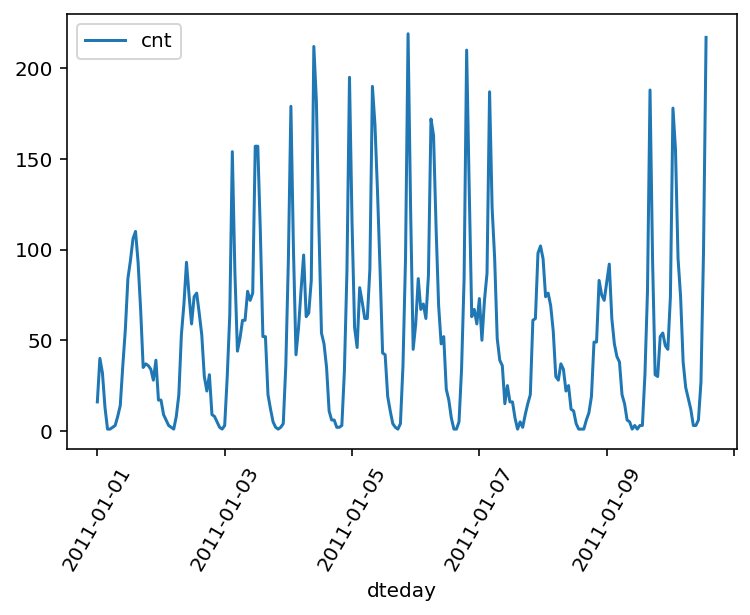

In [25]:
hour_rides[:24 * 10].plot(x='dteday', y='cnt')
plt.xticks(rotation=60)
plt.show()

### Dummy variables
Here we have some categorical variables like season, weather, month. To include these in our model, we'll need to make binary dummy variables. This is simple to do with Pandas thanks to `get_dummies()`.

In [26]:
fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']

for each in fields:
    dummies = pd.get_dummies(hour_rides[each], prefix=each, drop_first=False)
    hour_rides = pd.concat([hour_rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 'weekday', 'atemp', 'mnth', 'workingday', 'hr']

data = hour_rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


### Scaling target variables
To make training the network easier, we'll standardize each of the continuous variables. That is, we'll shift and scale the variables such that they have zero mean and a standard deviation of 1.

The scaling factors are saved so we can go backwards when we use the network for predictions.

In [27]:
# save the last 21 days
test_data = data[-21 * 24:]

# remove test data
data = data[:-21 * 24]

quant = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']

# store scaling in dict for future conversion
scaled_features = {}

for each in quant:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean) / std
    test_data.loc[:, each] = (test_data[each] - mean) / std

### Splitting the data into training, testing, and validation sets

We'll save the data for the last approximately 21 days to use as a test set after we've trained the network. We'll use this set to make predictions and compare them with the actual number of riders.

In [28]:
# separate data into features and targets
target = ['cnt', 'casual', 'registered']

features, targets = data.drop(target, axis=1), data[target]
test_features, test_targets = test_data.drop(target, axis=1), test_data[target]

In [29]:
X_train, y_train = features[:-60 * 24], targets[:-60 * 24]
X_val, y_val = features[-60 * 24:], targets[-60 * 24:]

In [43]:
from utils import NeuralNetwork

def MSE(y, Y):
    return np.mean((y - Y)**2)

In [44]:
import sys

####################
### Set the hyperparameters in you myanswers.py file ###
####################

from utils import iterations, learning_rate, hidden_nodes, output_nodes


N_i = X_train.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for ii in range(iterations):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(X_train.index, size=128)
    X, y = X_train.iloc[batch].values, y_train.iloc[batch]['cnt']

    network.train(X, y)

    # Printing out the training progress
    train_loss = MSE(np.array(network.run(X_train)).T, y_train['cnt'].values)
    val_loss = MSE(np.array(network.run(X_val)).T, y_val['cnt'].values)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()

    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

Progress: 100.0% ... Training loss: 0.079 ... Validation loss: 0.221